In [10]:
import numpy as np
import torch

In [11]:
inputs = torch.randn(50,16,50,100)

In [12]:
class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(16,32,kernel_size=3,padding=1)
        self.conv2 = torch.nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv3 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.conv4 = torch.nn.Conv2d(128,64,kernel_size=3,padding=1)
        
        self.convretro1 = torch.nn.Conv2d(16,64,kernel_size=1)
        self.convretro2 = torch.nn.Conv2d(32,128,kernel_size=1)
    
    def forward(self,inputs):
        o1 = self.conv1(inputs)
        o2 = self.conv2(o1)
        
        o3 = self.conv3(o2+self.convretro1(inputs))
        print(o2.shape, self.convretro1(inputs).shape)
        o4 = self.conv4(o3+self.convretro2(o1))
        

        return o4
        

In [13]:
model = ResNet()

In [14]:
output = model.forward(inputs)

torch.Size([50, 64, 50, 100]) torch.Size([50, 64, 50, 100])


In [15]:
from skimage import io
from torch.utils.data import Dataset, DataLoader
import os, csv
import torch.nn as nn
import matplotlib.pyplot as plt


In [16]:
csv_path = "C:\\Users\\Hugues\\Documents\\SCOLARITE\\CS\\AUTOMATANTS\\InterCentrales\\assignment-2023\\image_series.csv"
mode = "train"
batch_size = 20
shuffle_data = 'True'

In [17]:
class BaselineDataset(Dataset):
    """
    Baseline pytorch dataset for the competition data.
    Note that it does not leverage mask information, augment the data nor normalise it in any way.
    """

    def __init__(self):
        data_directory = os.path.dirname(os.path.abspath(csv_path))
        print(data_directory)
        self.s1_folder = os.path.join(data_directory, "s1")
        self.s2_folder = os.path.join(data_directory, "s2")
        self.masks_folder = os.path.join(data_directory, "s2-mask")

        with open(csv_path) as path_list:
            self.data_paths = [[os.path.basename(path) for path in row] for row in csv.reader(path_list, delimiter=",")][1:]
            

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index: int) -> dict:
        """ Reads a sample from the disk and returns it in the form of a dictionary. """

        paths = self.data_paths[index]
        s1 = [load_image(os.path.join(self.s1_folder, i)) for i in paths]
        if mode == "infer":
            s2 = [load_image(os.path.join(self.s2_folder, i)) for i in paths[:-1]]
            masks = [load_image(os.path.join(self.masks_folder, i)) for i in paths[:-1]]
            label = None
            label_mask = None
        else:
            s2 = [load_image(os.path.join(self.s2_folder, i)) for i in paths]
            masks = [load_image(os.path.join(self.masks_folder, i)) for i in paths]
            label = s2.pop(-1)
            label_mask = masks.pop(-1)

        return {
            "paths": paths,
            "s1": torch.from_numpy(np.concatenate(s1, axis=-1, dtype='float32')),
            "s2": torch.from_numpy(np.concatenate(s2, axis=-1,dtype='float32')),
            "masks": torch.from_numpy(np.concatenate(masks, axis=-1,dtype='float32')),
            "label": torch.from_numpy(label) if label is not None else [0],
            "label_mask": torch.from_numpy(label_mask) if label_mask is not None else [0],
        }


def get_loader():
    """ Get a loader for the data for batching and shuffling. """
    dataset = BaselineDataset()
    return DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=shuffle_data)


def load_image(path: str) -> np.ndarray:
    """ Loads TIFF images and returns a numpy array with shape (256, 256, channels). """
    image = io.imread(path)
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    return image

In [18]:
get_load = get_loader()

C:\Users\Hugues\Documents\SCOLARITE\CS\AUTOMATANTS\InterCentrales\assignment-2023


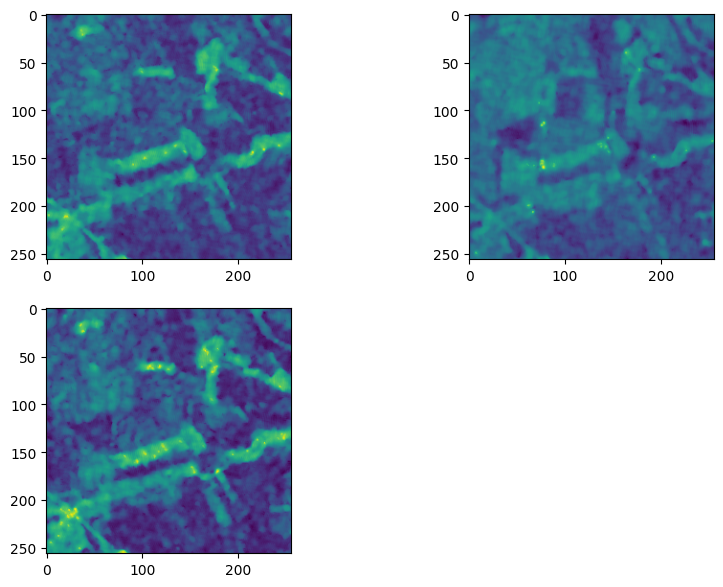

In [23]:
fig = plt.figure(figsize=(10,7))
rows = 2
columns = 2
fig.add_subplot(rows,columns,1)
a=iter(get_load)
images = next(a)
plt.imshow(images['s1'][0,:,:,0])
fig.add_subplot(rows,columns,2)
plt.imshow(images['s1'][0,:,:,1])
fig.add_subplot(rows,columns,3)
plt.imshow(images['s1'][0,:,:,2])


In [22]:
L=[0 for i in range(12)]
length_loader=len(get_load)

n=0
deno=1
c=0
for i in get_load:
    image=next(iter(get_load))
    mask_image=image['masks']
    arr=np.array(mask_image[0,:,:,1])
    arr2=np.array(mask_image[0,:,:,0])
    siz=arr.size
    siz2=arr2.size
    c+=1
    #print(new_deno)
    counter_nonzero=0
    
    for j in range(1,12):
        countfj_nonzero=np.count_nonzero(arr== j)
        countfj_nonzero2=np.count_nonzero(arr2== j)
        #print(countfj_nonzero)
        counter_nonzero+=countfj_nonzero+countfj_nonzero2
        #print(coef)
        L[j]+=(countfj_nonzero+countfj_nonzero2)/deno
    
    L[0]+=(siz+siz2 - counter_nonzero)
    deno=n+siz+siz2
    coef=(n+1)/(deno)
    
    L=[i*coef for i in L]
    n=deno
    if c%10==0:
        print(L)
   
        
print(L)

[26214.599127604117, 0.0, 0.001739511150351829, 0.006495685284833932, 0.6475686780258064, 0.28353577257525897, 0.0, 0.0051071514277655, 0.0010467572805087017, 0.003892528897258524, 0.0006225603937543445, 0.0]
[13114.971444716646, 0.0, 0.007778200583257542, 0.005754885278450656, 0.5581227847800926, 0.331876874409119, 0.05348152465452903, 0.007568405350436892, 0.0017524779169906587, 0.0065399354321527235, 0.0021301341779584606, 0.0]
[54618.66927726011, 0.0, 0.006344136011840965, 0.003836602301273892, 0.5487039579855316, 0.35738277275633457, 0.03566361765254461, 0.007689464306510807, 0.0012303747895384951, 0.0043599707231583434, 0.001461801365617421, 0.0]
[40964.09318233647, 0.0, 0.007813689473993584, 0.0034656857323934393, 0.5648066485621575, 0.3563533653514221, 0.027103684701510356, 0.009801919778157349, 0.0010719381182378678, 0.003443554433907412, 0.0011459446279992525, 0.0]
[231407.08444891055, 0.0, 0.0065317242958915596, 0.0029257518031537686, 0.5592825437358931, 0.33269157171924635,

KeyboardInterrupt: 

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
50.274986267089844 33.347984313964844 0.03274669125676155 0.14426687448969697


(<matplotlib.image.AxesImage at 0x231b604dd00>,
 Text(0.5, 1.0, 'image5-image6'))

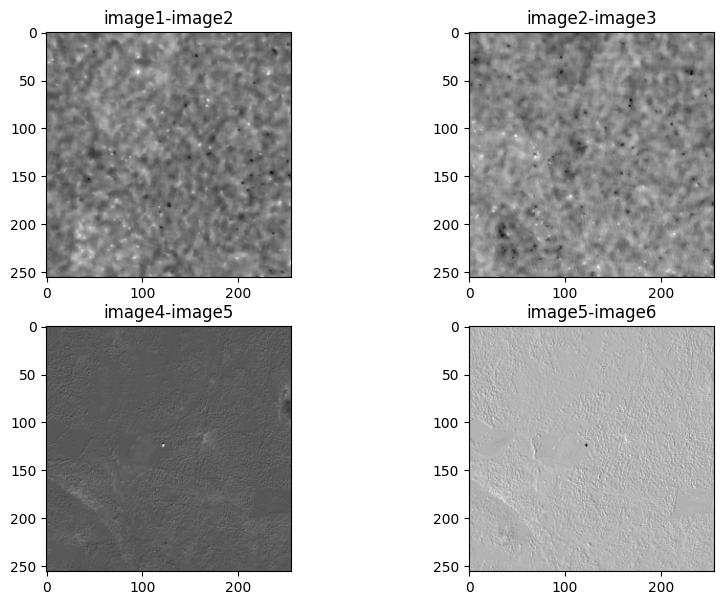

In [44]:

import cv2

fig = plt.figure(figsize=(10,7))
rows = 2
columns = 2


a=iter(get_load)
images = next(a)
image1=np.array(images['s1'][0,:,:,0])
image2=np.array(images['s1'][0,:,:,1])
image3=np.array(images['s1'][0,:,:,2])

image4=np.array(images['s2'][0,:,:,0])
image5=np.array(images['s2'][0,:,:,1])
image6=np.array(images['label'][0,:,:,0])
print(type(image5),type(image6))
#image1= plt.imread(images['s1'][0,:,:,0])

#image2= plt.imread(images['s1'][0,:,:,1])

#image3= plt.imread(images['s1'][0,:,:,2])

def error(img1,img2):
    h,w=img1.shape
    diff=img2 - img1
    err=np.sum(diff**2)
    mse=err/(float(h*w))
    return mse,diff
    
mse12,diff12=error(image1,image2)
mse23,diff23=error(image2,image3)

mse45,diff45=error(image4,image5)
mse56,diff56=error(image5,image6)

#remove sparkle noise

print(mse12,mse23,mse45,mse56)

fig.add_subplot(rows,columns,1)
plt.imshow(diff12,'gray'),plt.title("image1-image2")
fig.add_subplot(rows,columns,2)
plt.imshow(diff23,'gray'),plt.title("image2-image3")

fig.add_subplot(rows,columns,3)
plt.imshow(diff45,'gray'),plt.title("image4-image5")
fig.add_subplot(rows,columns,4)
plt.imshow(diff56,'gray'),plt.title("image5-image6")
